# Gradients and quiver

In [3]:
%%time
import os
import time
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sympy import *
import json
import geojsoncontour
import folium
import geopandas as gpd
from pyproj import Geod


import os
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata

path = 'd:/repos/pirnacasestudy'
sys.path.append('d:/repos/pirnacasestudy')
import SmartControl as sc

os.chdir(path)
Get = sc.queries.Get('Data/database.db')

In [2]:
plt.rcParams["figure.figsize"] = (10, 5) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

## 1. 1D numpy grad

1. Suppose we have two points and we want to get the derivative or gradient

In [25]:
x = np.array( [ 10 , 100 ] ) # x coordinates
y = np.array ( [ 30, 100 ] ) # y coordinates

#size 1 
def grad (x,y, s):
    dx = np.gradient(x, s)
    dy = np.gradient (y, s)
    print (f'The gradient of x and y is: {dx}, {dy} for space {s}')

for i in range(5):
    grad(x,y,i+1)

The gradient of x and y is: [90. 90.], [70. 70.] for space 1
The gradient of x and y is: [45. 45.], [35. 35.] for space 2
The gradient of x and y is: [30. 30.], [23.33333333 23.33333333] for space 3
The gradient of x and y is: [22.5 22.5], [17.5 17.5] for space 4
The gradient of x and y is: [18. 18.], [14. 14.] for space 5


If we add the third element, we see:

$$  dx_0 = x_1 - x_2 $$

$$ dx_1 = \frac {(x_2 - x_0 )}{2} $$

* and the division by two of inner element it is because it jumps over the position one and goes to position two to calculate the gradient exatcly at the position 1. Because the distance is now twice as big, if the array is uniform, then the gradient is half of that.

$$ dx_2 = x_2 - x_1 $$

If the **edge order** is set as default, which is  **1**, then we see the edge is the exact difference between the bordering elements.

In [26]:
x = np.array( [ 10 , 100 , 150] ) # x coordinates
y = np.array ( [ 30, 100 , 160 ] ) # y coordinates

for i in range(5):
    grad(x,y,i+1)

The gradient of x and y is: [90. 70. 50.], [70. 65. 60.] for space 1
The gradient of x and y is: [45. 35. 25.], [35.  32.5 30. ] for space 2
The gradient of x and y is: [30.         23.33333333 16.66666667], [23.33333333 21.66666667 20.        ] for space 3
The gradient of x and y is: [22.5 17.5 12.5], [17.5  16.25 15.  ] for space 4
The gradient of x and y is: [18. 14. 10.], [14. 13. 12.] for space 5


Test edge order. What does it do?

**What if we increase the edge ?**

In [29]:
#size 1 
def grad (x,y ):
    dx = np.gradient(x, edge_order = 2)
    dy = np.gradient (y, edge_order = 2)
    print (f'The gradient of x and y is: {dx}, {dy} for edge = 2')


grad(x,y)

The gradient of x and y is: [110.  70.  30.], [75. 65. 55.] for edge = 2


* We see that the edge order is an **extrapolation** of the gradient.
* It increases or decreases the values based on the inner derivatives.
* In this example, the border is $ d_0 = d_1 - d_0 $, but it is:
$$ dx_0 = x_1 - x_0 \pm (dx_1 - dx_0) $$

* We see that if we grow the space/ distance in between the elements of our array, the derivative/slope/gradient obviously decreases.

* The space is therefore the distance between the point at the axis where we are computing the derivative

**Let's add a new dimension to the problem and see:**

**What happens if we apply the real space?**

In [19]:
z = np.array ( [ 100, 105 ] ) 

def graddz_dx(z, x):
    dz = np.gradient (z, x)
    print (f'The partial gradient of z is: {dz}, for spacing {x}')
graddz_dx(z, x)

The partial gradient of z is: [0.05555556 0.05555556], for spacing [ 10 100]


In [21]:
# comparison
dx = x[1] - x[0]
dz = z[1]- z[0]
grad = dz / dx
print (f'The gradient is: {grad}')

The gradient is: 0.05555555555555555


## 2. 1d problems along the x axis

In [106]:
x = Symbol('x')
f = x**2
df_dx = diff(f, x)
f1 = lambdify (x, f)

In [159]:
x_arr = np.linspace(0,100, 101)

x = Symbol ('x')
f = x_**2
s_dz_dx = diff(f, x) #symbol of analytical derivative

fz = lambdify(x, f) # function f was attributed to the Z dimension
z = fz(x_arr) 

s_dz_dx

2*x

In [165]:
def edge_order (o):

    '''
    Numerical
    '''
    num_dz = np.gradient(z, x_arr, edge_order = o)#numerical derivative = gradient

    '''
    Analytical
    '''
    dz_dx = 2*x_arr #function of derivative



    '''
    Plotting

    '''

    plt.subplot(221)
    plt.plot(x_arr, z, color = 'b', label = '$x^2$')
    plt.plot (x_arr, num_dz , color = 'g' , label = r'Gradient $\frac{d_z}{d_x}$')
    plt.grid()
    plt.title(f'Edge order = {o}')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$z$ (m)')
    plt.legend()

    plt.subplot(222)
    plt.plot (x_arr, num_dz , color = 'g' , label = r'Gradient  $\frac{d_z}{d_x}$')
    plt.plot (x_arr, dz_dx , color = 'r' , label = r'Derivative : $2 \cdot x$')
    plt.grid()
    plt.xlabel('$x$ (m)')
    plt.title(f'Edge order = {o}')
    plt.ylabel('$z$ (m)')
    plt.legend()
    plt.show()


    plt.subplot(2,2,3)

    z_ = num_dz - dz_dx

    plt.plot (x_arr, z_ , color = 'g' , label = r'$ \frac{\frac{d_z}{d_x}}{2 \cdot x}$')
    plt.grid()
    plt.xlabel('$x$ (m)')
    plt.ylabel('$z$ (m)')
    plt.title(f'Edge order = {o}')
    plt.legend()
    
    return plt.show()

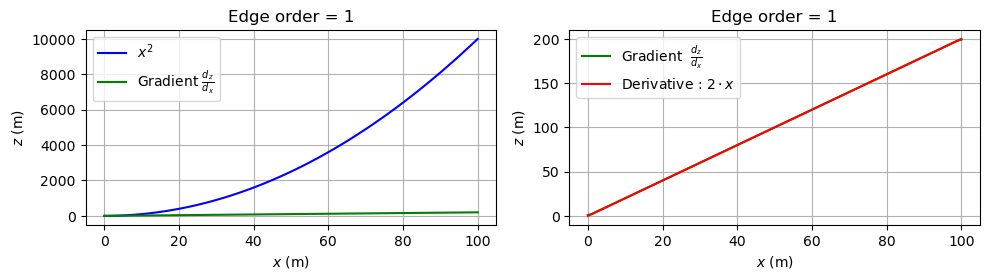

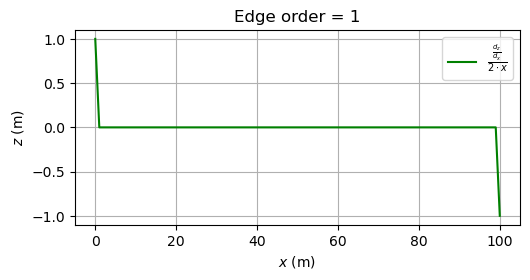

In [166]:
edge_order (1)

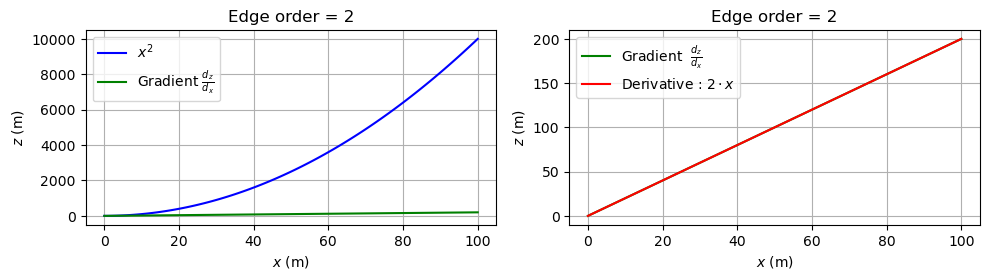

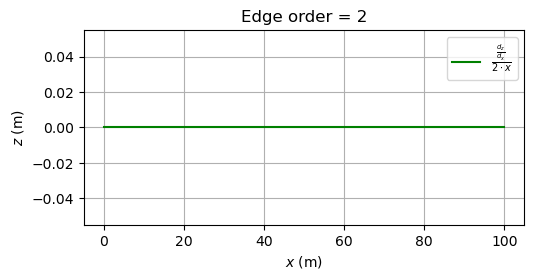

In [167]:
edge_order (2)

**We can see that the numpy.gradient accurately computes the derivative**

let us think about heads in one horizon now

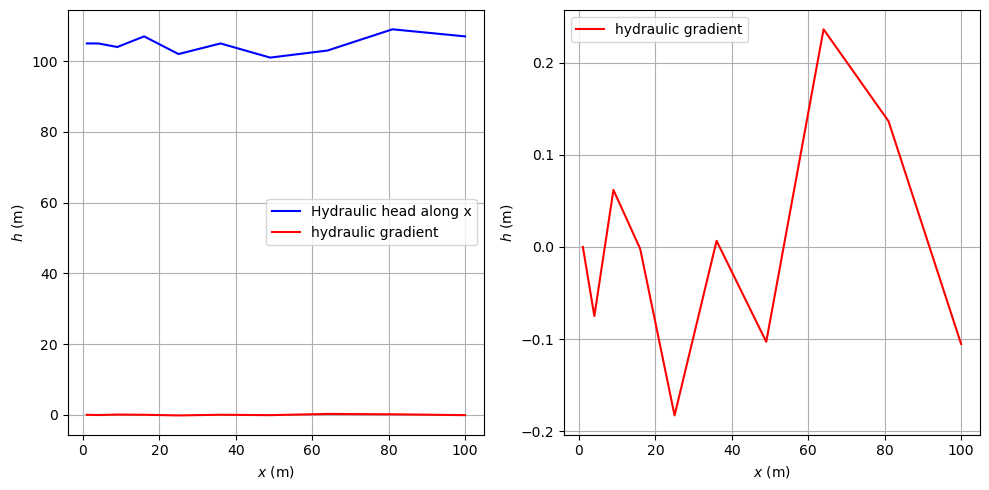

In [181]:
x = np.linspace(1,10,10)
x = np.power(x,2) #space in x is growing
np.random.seed(30)
h = np.random.randint(100, 110, 10) #heads

grad_i = np.gradient(h, x) # hydraulic gradient over x

plt.subplot(121)
plt.plot (x, h , color = 'b' , label = 'Hydraulic head along x')
plt.plot (x, grad_i , color = 'r' , label = 'hydraulic gradient')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$h$ (m)')
plt.legend()

plt.subplot(122)
plt.plot (x, grad_i , color = 'r' , label = 'hydraulic gradient')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$h$ (m)')
plt.legend()
plt.show()


In [255]:
x_list = list(np.diff(x))
x_list.append(21.)
x_quiver = np.array(x_list)


h_list = list(np.diff(h))
h_list.append(1.)
h_quiver = np.array(h_list)

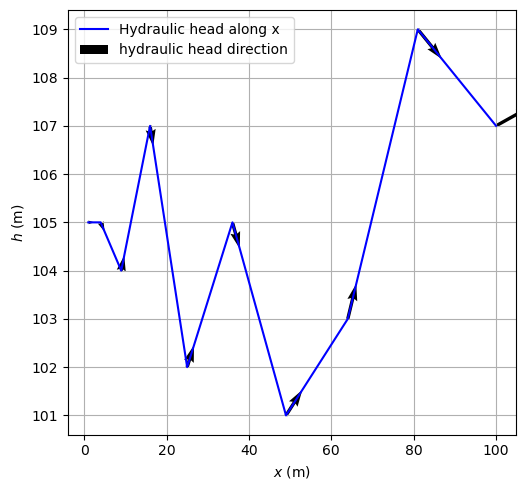

In [262]:
plt.subplot(121)
plt.plot (x, h , color = 'b' , label = 'Hydraulic head along x')
plt.quiver(x, h, x_quiver, h_quiver, angles = 'xy' , label = 'hydraulic head direction')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$h$ (m)')
plt.legend()


plt.show()

## 3. 2D Problem with groundwater heads

In [5]:
import sys
import os
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata

path = 'd:/repos/pirnacasestudy'
sys.path.append('d:/repos/pirnacasestudy')
import SmartControl as sc

os.chdir(path)
Get = sc.queries.Get('Data/database.db')

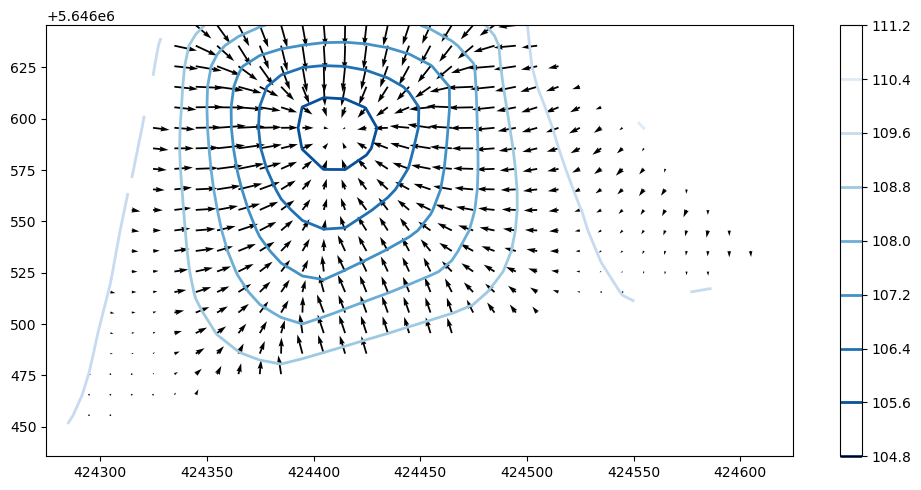

In [13]:
crs = 4326
res = 10 # 5 meters
dst_crs = 'EPSG:25833'

date_wid = pd.to_datetime('2022/12/12 12')

Get.Isolines(Year = pd.to_datetime(date_wid.value).year,
                  Month = pd.to_datetime(date_wid.value).month,
                  Day = pd.to_datetime(date_wid.value).day,
                  Hour = pd.to_datetime(date_wid.value).hour)

df  = Get.Isolines_df.copy()

df = df.dropna()

df_ = sc.utils.ControlPoints()
df = sc.utils.BoundaryCondition(df, df_).reset_index(drop = True)

df.loc [df.MonitoringPointName.str.len()>4 , 'cut'] = 1
df.loc [df.MonitoringPointName.str.len() <= 4 , 'cut'] = 0
gwms_mean = df[df.cut == 1].Value.mean()
df = df [~ df.index.isin (df[df.cut == 1].index[1:])]
df.loc [df.cut == 1, 'Value'] = gwms_mean
df = df.drop('cut', axis =1)

map_df = df.copy()
map_gdf = gpd.GeoDataFrame(map_df, geometry = gpd.points_from_xy (map_df.E, map_df.N), crs = crs).reset_index(drop = True)

'''
folium elements

'''

# Create a geometry list from the GeoDataFrame to pass into folium map
points_list = [list(i[1].values) for i in map_gdf[['N', 'E']].iterrows()]
map_center = map_gdf.N.mean(), map_gdf.E.mean() #in folium y comes before x

'''
Gradient
'''

# 1. convert it to utm to get a real gradient

map_gdf = map_gdf.to_crs(dst_crs)


# 2. Linear interpolation 

# 2.1 fetching converted points
points = np.array( pd.DataFrame ( 
                    {
                        'x' : map_gdf.geometry.x ,
                        'y' : map_gdf.geometry.y
                    }
                                 )
                 )


# points = np.array(map_df[['E','N']])


# 2.2 Fetching values
values = np.array(map_df.Value)

# 2.3 preparing the grids
minx, maxx = map_gdf.geometry.x.min(), map_gdf.geometry.x.max()
miny, maxy = map_gdf.geometry.y.min(), map_gdf.geometry.y.max()

grid_x , grid_y = np.mgrid [minx:maxx:res, miny:maxy:res]  


# 2.4 interpolating
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

u, v = np.gradient(grid_z, res)

#increase the scale of the plot
U =  - u 
V =  - v 

x = grid_x
y = grid_y


fig, ax = plt.subplots()

# kw = dict(color='black', alpha=0.1, scale=1)
contour = plt.contour(grid_x, grid_y, grid_z, linewidths = 2 , cmap = reversed_map)
plt.colorbar()

q = ax.quiver(x, y, U, V)



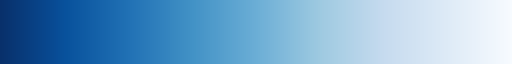

In [12]:
reversed_map

### 2.1 Confirming that the gradient indeed represents the right value

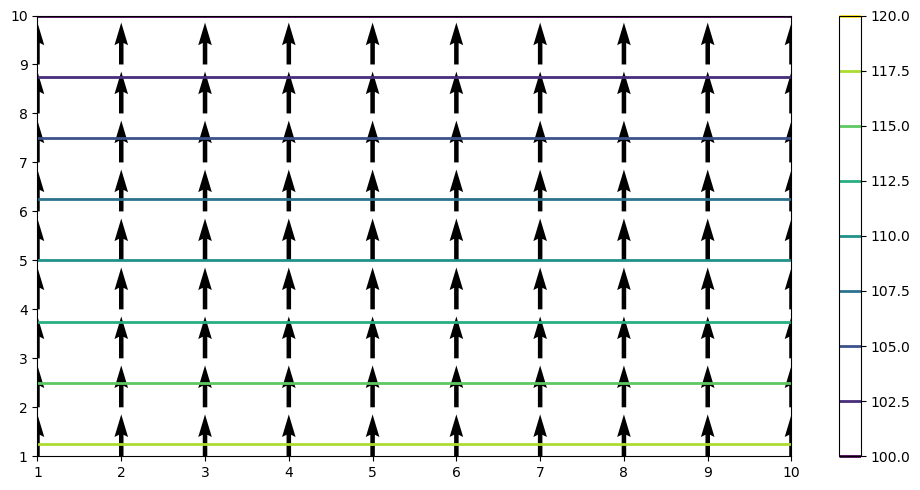

In [704]:
grid_x , grid_y = np.mgrid [1:11:1, 1:11:1]  

grid_z = np.linspace(118, 100, 10)
arrays = [grid_z for _ in range(10)]

grid_z = np.stack(arrays, axis = 0)

u, v = np.gradient(grid_z, 1)

#increase the scale of the plot
U =  - u 
V =  - v 

x = grid_x
y = grid_y



contour = plt.contour(grid_x, grid_y, grid_z, linewidths = 2)
plt.colorbar()

# kw = dict(color='black', alpha=0.8, scale=10)
q = plt.quiver(x, y, U, V)
plt.show()

1. The grid in the y direction varies has a resolution of 1 m

2. The head values vary constantly (constant derivative or gradient) only in the y direction. They are equal 2

**These values can indeed be interpreted as groundwater heads**


**Useful links about gradient and grids using numpy**

[mgrid vs-meshgrid](http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/)

[groundwater analytical modelling](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/chapter1/chapter1_bakker_post.ipynb)

[explaining complicated gradients](https://stackoverflow.com/questions/17901363/gradient-calculation-with-python)


## 4. Prepare to plot it in Folium

it worked! but small problem with signals and orientation

## Folium

In [ ]:
impo

In [12]:
%%time
date_wid = pd.to_datetime('2022/12/12 00')

map_gdf = sc.utils.prepare_query (Get, date_wid )
grid_x_gcs , grid_y_gcs , grid_z_gcs, U , V = sc.utils.Interpolation_Gradient (map_gdf , crs_utm = 25833 , pixel_size = 10)

x = grid_x_gcs
y = grid_y_gcs

arrows_df = sc.utils.arrow_head (grid_x_gcs , grid_y_gcs , grid_z_gcs, U , V , scale = 100)
df = arrows_df [ arrows_df.index.isin( np.arange(0 ,
                                                 arrows_df.shape[0],
                                                 2
                                                )
                                     )
               ].reset_index (drop = True)



Map = sc.utils.Folium_map(Get)

Map_contour = sc.utils.Folium_contour ( 
    
    Map , map_gdf , grid_x_gcs , grid_y_gcs , grid_z_gcs
    
                                      )

# arrows_df
sc.utils.Folium_arrows(Map_contour , df )


Wall time: 213 ms
